In [3]:
import os
import random
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import glob

# --- CONFIGURATION (UPDATED) ---
# Root based on your screenshot
ROOT_DIR = "/kaggle/input/pascal-voc-2012/VOC2012"

# Map the PASCAL VOC Original Indices to your 0-4 range
# Standard PASCAL VOC Order: 
# [aeroplane, bicycle, bird, boat, bottle, bus, car, cat, chair, cow, 
#  diningtable, dog, horse, motorbike, person, pottedplant, sheep, sofa, train, tvmonitor]
# Indices: Bottle=4, Car=6, Dog=11, Person=14, Sofa=17
TARGET_CLASS_IDS = [4, 6, 11, 14, 17] 

# Map original ID to new ID (0, 1, 2, 3, 4)
ID_MAPPING = {4: 0, 6: 1, 11: 2, 14: 3, 17: 4}
TARGET_CLASSES_NAMES = ["bottle", "car", "dog", "person", "sofa"]

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16 
LEARNING_RATE = 1e-4 
NUM_EPOCHS = 30 
IMG_SIZE = 448 
GRID_SIZE = 7  
NUM_BBOX = 2   
NUM_CLASSES = 5

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
print(f"Device: {DEVICE}")

Device: cuda


In [4]:
def create_fixed_subset():
    print(f"Scanning {ROOT_DIR} for target classes...")
    valid_entries = [] # Stores tuple (image_path, label_path)
    
    # 1. Collect all label files from both train and val folders
    # Your structure seems to be labels/train and labels/val
    all_label_files = glob.glob(os.path.join(ROOT_DIR, "labels", "**", "*.txt"), recursive=True)
    
    print(f"Found {len(all_label_files)} total label files. Filtering...")

    for label_path in tqdm(all_label_files, desc="Filtering Dataset"):
        try:
            with open(label_path, "r") as f:
                lines = f.readlines()
            
            has_target = False
            for line in lines:
                parts = line.strip().split()
                if len(parts) > 0:
                    class_id = int(float(parts[0])) # Convert '4.0' or '4' to int
                    if class_id in TARGET_CLASS_IDS:
                        has_target = True
                        break
            
            if has_target:
                # Infer image path from label path
                # labels/train/image1.txt -> images/train/image1.jpg
                img_path = label_path.replace("labels", "images").replace(".txt", ".jpg")
                
                if os.path.exists(img_path):
                    valid_entries.append(f"{img_path},{label_path}")
        except Exception as e:
            continue
            
    # 2. Random Shuffle & Split (80/20)
    # We mix train/val together to create YOUR custom split
    random.shuffle(valid_entries)
    split_idx = int(len(valid_entries) * 0.8)
    train_files = valid_entries[:split_idx]
    val_files = valid_entries[split_idx:]
    
    # 3. Save "Locked" Splits
    with open("final_train_split.txt", "w") as f:
        f.write("\n".join(train_files))
    with open("final_val_split.txt", "w") as f:
        f.write("\n".join(val_files))
        
    print(f"\n[LOCKED] Training Samples: {len(train_files)}")
    print(f"[LOCKED] Validation Samples: {len(val_files)}")
    print("Files 'final_train_split.txt' and 'final_val_split.txt' saved.")

if not os.path.exists("final_train_split.txt"):
    create_fixed_subset()
else:
    print("Split files found. Using existing splits.")

Scanning /kaggle/input/pascal-voc-2012/VOC2012 for target classes...
Found 11540 total label files. Filtering...


Filtering Dataset:   0%|          | 0/11540 [00:00<?, ?it/s]


[LOCKED] Training Samples: 5120
[LOCKED] Validation Samples: 1281
Files 'final_train_split.txt' and 'final_val_split.txt' saved.


In [7]:
import albumentations as A
import cv2
from albumentations.pytorch import ToTensorV2

def get_train_transforms():
    return A.Compose([
        # --- Geometric Augmentations ---
        A.LongestMaxSize(max_size=IMG_SIZE),
        # Updated PadIfNeeded: 'value' is deprecated/renamed in some versions, 
        # but defaults (0) work for BORDER_CONSTANT usually. 
        # We use standard border_mode without explicit 'value' to be safe across versions.
        A.PadIfNeeded(
            min_height=IMG_SIZE, 
            min_width=IMG_SIZE, 
            border_mode=cv2.BORDER_CONSTANT, 
            value=0
        ),
        A.HorizontalFlip(p=0.5),
        # ShiftScaleRotate is safe, ignore the "Affine" warning, it's just a suggestion
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
        
        # Updated ElasticTransform: Removed 'alpha_affine' which causes errors in new versions
        A.ElasticTransform(alpha=1, sigma=50, p=0.2), 
        
        # --- Pixel-level Augmentations ---
        A.RandomBrightnessContrast(p=0.5),
        A.CLAHE(clip_limit=4.0, p=0.3), 
        A.GaussianBlur(blur_limit=(3, 7), p=0.2),
        
        # --- Regularization (Updated CoarseDropout for v1.4+) ---
        # Old: max_holes=8, max_height=32...
        # New: num_holes_range, hole_height_range...
        A.CoarseDropout(
            num_holes_range=(2, 8), 
            hole_height_range=(10, 32), 
            hole_width_range=(10, 32), 
            fill_value=0, 
            p=0.3
        ),
        
        # --- Normalize & Tensor ---
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ], bbox_params=A.BboxParams(format='yolo', min_visibility=0.4, label_fields=['class_labels']))

def get_val_transforms():
    return A.Compose([
        A.LongestMaxSize(max_size=IMG_SIZE),
        A.PadIfNeeded(min_height=IMG_SIZE, min_width=IMG_SIZE, border_mode=cv2.BORDER_CONSTANT, value=0),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ], bbox_params=A.BboxParams(format='yolo', min_visibility=0.4, label_fields=['class_labels']))

In [8]:
class VOCCustomDataset(Dataset):
    def __init__(self, split_file, transforms=None):
        with open(split_file, "r") as f:
            self.files = f.read().splitlines()
        self.transforms = transforms
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, index):
        line = self.files[index]
        # Robust split to handle potential issues
        parts = line.split(',')
        if len(parts) != 2:
            return self.__getitem__((index + 1) % len(self.files))
            
        img_path, label_path = parts
        
        # 1. Load Image
        image = cv2.imread(img_path)
        if image is None:
            return self.__getitem__((index + 1) % len(self.files))
            
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # 2. Load Labels
        boxes = []
        class_labels = []
        
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                lines = f.readlines()
                
            for line in lines:
                parts = line.strip().split()
                if len(parts) == 5:
                    cls_id = int(float(parts[0]))
                    
                    if cls_id in TARGET_CLASS_IDS:
                        new_id = ID_MAPPING[cls_id]
                        x, y, w, h = map(float, parts[1:])
                        boxes.append([x, y, w, h])
                        class_labels.append(new_id)
        
        # 3. Apply Augmentations
        if self.transforms:
            try:
                # Albumentations requires labels to be passed if label_fields is set
                augmented = self.transforms(image=image, bboxes=boxes, class_labels=class_labels)
                image = augmented['image']
                boxes = augmented['bboxes']
                class_labels = augmented['class_labels']
            except Exception as e:
                # If augmentation fails (e.g. bbox clipped out), return next image
                return self.__getitem__((index + 1) % len(self.files))

        # 4. Prepare Target Grid
        label_matrix = torch.zeros((GRID_SIZE, GRID_SIZE, NUM_CLASSES + 5 * NUM_BBOX))
        
        for box, cls_idx in zip(boxes, class_labels):
            x, y, width, height = box
            
            # Ensure index is an INTEGER (Fixes IndexError)
            cls_idx = int(cls_idx)
            
            # 7x7 Grid Logic
            i, j = int(GRID_SIZE * y), int(GRID_SIZE * x)
            
            # Safety Check: Augmentations might push center slightly off bounds
            if i >= GRID_SIZE: i = GRID_SIZE - 1
            if j >= GRID_SIZE: j = GRID_SIZE - 1
            if i < 0: i = 0
            if j < 0: j = 0
            
            x_cell, y_cell = GRID_SIZE * x - j, GRID_SIZE * y - i
            width_cell, height_cell = width * GRID_SIZE, height * GRID_SIZE
            
            if label_matrix[i, j, NUM_CLASSES] == 0:
                label_matrix[i, j, cls_idx] = 1 # One-Hot Class
                
                box_coordinates = torch.tensor([x_cell, y_cell, width_cell, height_cell])
                
                # Box 1
                label_matrix[i, j, NUM_CLASSES] = 1 # Confidence
                label_matrix[i, j, NUM_CLASSES+1:NUM_CLASSES+5] = box_coordinates
                
                # Box 2 (Baseline logic: assign same truth to both anchors)
                label_matrix[i, j, NUM_CLASSES+5] = 1 
                label_matrix[i, j, NUM_CLASSES+6:NUM_CLASSES+10] = box_coordinates
                
        return image, label_matrix

# --- Re-Initialize Loaders with Fixed Code ---
train_dataset = VOCCustomDataset("final_train_split.txt", get_train_transforms())
val_dataset = VOCCustomDataset("final_val_split.txt", get_val_transforms())

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=2, 
    pin_memory=True,
    drop_last=True # Prevents bad batch sizes at end of epoch
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=2,
    drop_last=True
)

# Test again
print("Testing fixed DataLoader...")
x, y = next(iter(train_loader))
print(f"Success! Batch Shape: {x.shape}, Target Shape: {y.shape}")

Testing fixed DataLoader...


/tmp/ipykernel_47/872832527.py:12: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(
/tmp/ipykernel_47/872832527.py:33: UserWarning: Argument(s) 'fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(
/tmp/ipykernel_47/872832527.py:49: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=IMG_SIZE, min_width=IMG_SIZE, border_mode=cv2.BORDER_CONSTANT, value=0),


Success! Batch Shape: torch.Size([16, 3, 448, 448]), Target Shape: torch.Size([16, 7, 7, 15])


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 1e-4
NUM_EPOCHS = 30 
GRID_SIZE = 7
NUM_BBOX = 2
NUM_CLASSES = 5

class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)
        self.leaky = nn.LeakyReLU(0.1)
        
    def forward(self, x):
        return self.leaky(self.bn(self.conv(x)))

class BaselineCustomDetector(nn.Module):
    def __init__(self, split_size=7, num_boxes=2, num_classes=5):
        super(BaselineCustomDetector, self).__init__()
        self.S = split_size
        self.B = num_boxes
        self.C = num_classes
        
        self.features = nn.Sequential(
            # Layer 1: 448 -> 224 -> 112
            CNNBlock(3, 64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Layer 2: 112 -> 56
            CNNBlock(64, 192, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Layer 3: 56 -> 56
            CNNBlock(192, 256, kernel_size=3, padding=1),
            CNNBlock(256, 512, kernel_size=1),
            
            # Layer 4: 56 -> 28
            CNNBlock(512, 1024, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Layer 5: 28 -> 14 -> 14
            CNNBlock(1024, 1024, kernel_size=3, padding=1, stride=2),
            CNNBlock(1024, 1024, kernel_size=3, padding=1),
            
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )
        
        self.fcs = nn.Sequential(
            nn.Flatten(),
            # Input: 1024 channels * 7 height * 7 width = 50176
            nn.Linear(1024 * 7 * 7, 4096), 
            nn.Dropout(0.5),
            nn.LeakyReLU(0.1),
            nn.Linear(4096, self.S * self.S * (self.C + self.B * 5))
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.fcs(x)
        return x.view(-1, self.S, self.S, (self.C + self.B * 5))

model = BaselineCustomDetector(split_size=GRID_SIZE, num_boxes=NUM_BBOX, num_classes=NUM_CLASSES).to(DEVICE)
print("Model initialized successfully!")

Model initialized successfully!


In [13]:
class CustomYoloLoss(nn.Module):
    def __init__(self, S=7, B=2, C=5):
        super(CustomYoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")
        self.S = S
        self.B = B
        self.C = C
        self.lambda_noobj = 0.5
        self.lambda_coord = 5.0

    def forward(self, predictions, target):
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)
        
        # Calculate IoU for the two predicted boxes
        iou_b1 = self.intersection_over_union(predictions[..., self.C+1:self.C+5], target[..., self.C+1:self.C+5])
        iou_b2 = self.intersection_over_union(predictions[..., self.C+6:self.C+10], target[..., self.C+1:self.C+5])
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)
        
        # Take the box with highest IoU as the "responsible" one
        iou_maxes, best_box = torch.max(ious, dim=0)
        exists_box = target[..., self.C].unsqueeze(3) # Iobj_i

        # --- Box Coordinates Loss ---
        box_predictions = exists_box * (
            (best_box * predictions[..., self.C+6:self.C+10] + (1 - best_box) * predictions[..., self.C+1:self.C+5])
        )
        box_targets = exists_box * target[..., self.C+1:self.C+5]
        
        # Sqrt for stability (sign(x)*sqrt(abs(x)))
        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(torch.abs(box_predictions[..., 2:4] + 1e-6))
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])
        
        box_loss = self.mse(torch.flatten(box_predictions, end_dim=-2), torch.flatten(box_targets, end_dim=-2))
        
        # --- Object Loss ---
        pred_box = (best_box * predictions[..., self.C+5:self.C+6] + (1 - best_box) * predictions[..., self.C:self.C+1])
        object_loss = self.mse(torch.flatten(exists_box * pred_box), torch.flatten(exists_box * target[..., self.C:self.C+1]))
        
        # --- No Object Loss ---
        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[..., self.C:self.C+1], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., self.C:self.C+1], start_dim=1)
        )
        no_object_loss += self.mse(
            torch.flatten((1 - exists_box) * predictions[..., self.C+5:self.C+6], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., self.C:self.C+1], start_dim=1)
        )
        
        # --- Class Loss ---
        class_loss = self.mse(
            torch.flatten(exists_box * predictions[..., :self.C], end_dim=-2),
            torch.flatten(exists_box * target[..., :self.C], end_dim=-2)
        )
        
        return (
            self.lambda_coord * box_loss +
            object_loss +
            self.lambda_noobj * no_object_loss +
            class_loss
        )

    def intersection_over_union(self, boxes_preds, boxes_labels):
        # Simplified IoU for loss calculation (assuming same cell reference)
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2
        
        x1 = torch.max(box1_x1, box2_x1)
        y1 = torch.max(box1_y1, box2_y1)
        x2 = torch.min(box1_x2, box2_x2)
        y2 = torch.min(box1_y2, box2_y2)
        
        intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
        box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
        box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))
        
        return intersection / (box1_area + box2_area - intersection + 1e-6)

loss_fn = CustomYoloLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, verbose=True)

Starting Training...


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch 1: New best model saved with Val Loss 154.5156
Epoch 1 -> Train Loss: 414.7395 | Val Loss: 154.5156


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch 2 -> Train Loss: 162.9691 | Val Loss: 159.0413


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch 3: New best model saved with Val Loss 139.7840
Epoch 3 -> Train Loss: 155.6817 | Val Loss: 139.7840


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch 4 -> Train Loss: 144.0466 | Val Loss: 155.9880


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch 5 -> Train Loss: 132.9739 | Val Loss: 208.1832


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch 6 -> Train Loss: 161.4933 | Val Loss: 238.5841


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch 7: New best model saved with Val Loss 125.1825
Epoch 7 -> Train Loss: 135.1811 | Val Loss: 125.1825


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch 8: New best model saved with Val Loss 118.5055
Epoch 8 -> Train Loss: 124.9664 | Val Loss: 118.5055


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch 9: New best model saved with Val Loss 116.3253
Epoch 9 -> Train Loss: 121.4701 | Val Loss: 116.3253


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch 10 -> Train Loss: 118.2693 | Val Loss: 116.8491


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch 11 -> Train Loss: 117.1844 | Val Loss: 119.0026


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch 12: New best model saved with Val Loss 114.9414
Epoch 12 -> Train Loss: 115.4018 | Val Loss: 114.9414


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch 13 -> Train Loss: 113.6042 | Val Loss: 115.0719


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch 14: New best model saved with Val Loss 108.2916
Epoch 14 -> Train Loss: 112.7376 | Val Loss: 108.2916


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch 15 -> Train Loss: 111.4790 | Val Loss: 114.4808


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch 16 -> Train Loss: 110.9771 | Val Loss: 110.4686


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch 17 -> Train Loss: 110.5746 | Val Loss: 136.5025


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch 18 -> Train Loss: 107.1677 | Val Loss: 110.2259


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch 19: New best model saved with Val Loss 108.0167
Epoch 19 -> Train Loss: 107.5233 | Val Loss: 108.0167


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch 20 -> Train Loss: 106.1038 | Val Loss: 110.3786


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch 21 -> Train Loss: 105.8403 | Val Loss: 111.0315


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch 22: New best model saved with Val Loss 107.6719
Epoch 22 -> Train Loss: 104.8935 | Val Loss: 107.6719


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch 23: New best model saved with Val Loss 104.5865
Epoch 23 -> Train Loss: 104.7580 | Val Loss: 104.5865


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch 24: New best model saved with Val Loss 104.5142
Epoch 24 -> Train Loss: 105.4687 | Val Loss: 104.5142


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch 25 -> Train Loss: 104.9786 | Val Loss: 104.6072


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch 26 -> Train Loss: 103.8341 | Val Loss: 105.6484


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch 27 -> Train Loss: 104.8642 | Val Loss: 105.4870


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch 28 -> Train Loss: 104.5477 | Val Loss: 106.7983


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch 29 -> Train Loss: 104.3911 | Val Loss: 108.8072


  0%|          | 0/320 [00:00<?, ?it/s]

Epoch 30 -> Train Loss: 104.4570 | Val Loss: 109.1513


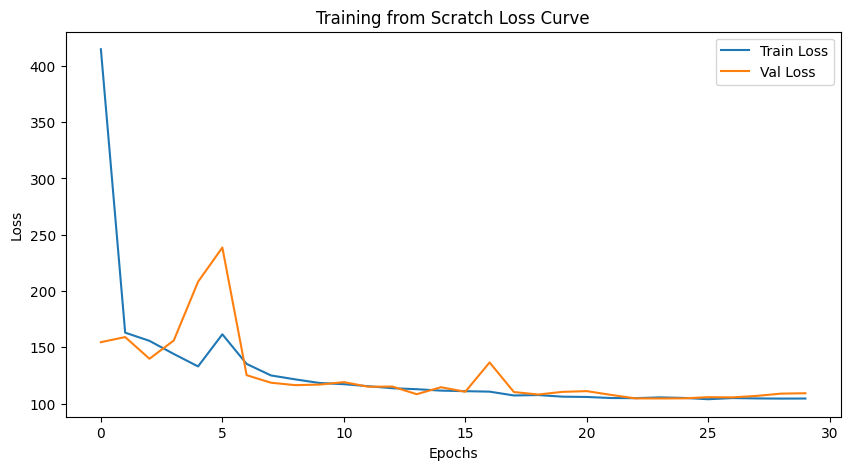

Training Complete. Best Model Saved to: custom_cnn_scratch.pth


In [14]:
train_losses = []
val_losses = []
best_loss = float('inf')
SAVE_PATH = "custom_cnn_scratch.pth"

print("Starting Training...")

for epoch in range(NUM_EPOCHS):
    model.train()
    loop = tqdm(train_loader, leave=True)
    mean_loss = []
    
    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)
        
        # Forward pass
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update progress bar
        loop.set_description(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
        loop.set_postfix(loss=loss.item())
        
    avg_train_loss = sum(mean_loss) / len(mean_loss)
    train_losses.append(avg_train_loss)
    
    # Validation
    model.eval()
    val_loss_epoch = []
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            out = model(x)
            loss = loss_fn(out, y)
            val_loss_epoch.append(loss.item())
    
    avg_val_loss = sum(val_loss_epoch) / len(val_loss_epoch)
    val_losses.append(avg_val_loss)
    
    scheduler.step(avg_val_loss)
    
    # Save Best Model
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save(model.state_dict(), SAVE_PATH)
        print(f"Epoch {epoch+1}: New best model saved with Val Loss {avg_val_loss:.4f}")
    
    print(f"Epoch {epoch+1} -> Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

# Plot Loss
plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training from Scratch Loss Curve")
plt.savefig("loss_curve.png")
plt.show()

print(f"Training Complete. Best Model Saved to: {SAVE_PATH}")

In [17]:
import torch
import numpy as np

def intersection_over_union(box1, box2):
    box1_x1 = box1[..., 0:1] - box1[..., 2:3] / 2
    box1_y1 = box1[..., 1:2] - box1[..., 3:4] / 2
    box1_x2 = box1[..., 0:1] + box1[..., 2:3] / 2
    box1_y2 = box1[..., 1:2] + box1[..., 3:4] / 2
    
    box2_x1 = box2[..., 0:1] - box2[..., 2:3] / 2
    box2_y1 = box2[..., 1:2] - box2[..., 3:4] / 2
    box2_x2 = box2[..., 0:1] + box2[..., 2:3] / 2
    box2_y2 = box2[..., 1:2] + box2[..., 3:4] / 2
    
    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)
    
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))
    
    return intersection / (box1_area + box2_area - intersection + 1e-6)

def convert_cell_boxes(predictions, S=7):
    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, 15)
    
    bboxes1 = predictions[..., 6:10]
    scores1 = predictions[..., 5].unsqueeze(3)
    
    bboxes2 = predictions[..., 11:15]
    scores2 = predictions[..., 10].unsqueeze(3)
    
    best_class = predictions[..., :5].argmax(3).unsqueeze(3)
    
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1)
    
    x = 1 / S * (bboxes1[..., 0:1] + cell_indices)
    y = 1 / S * (bboxes1[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_h = 1 / S * bboxes1[..., 2:4]
    converted_bboxes1 = torch.cat((best_class, scores1, x, y, w_h), dim=-1).reshape(batch_size, -1, 6)
    
    x = 1 / S * (bboxes2[..., 0:1] + cell_indices)
    y = 1 / S * (bboxes2[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_h = 1 / S * bboxes2[..., 2:4]
    converted_bboxes2 = torch.cat((best_class, scores2, x, y, w_h), dim=-1).reshape(batch_size, -1, 6)
    
    return torch.cat((converted_bboxes1, converted_bboxes2), dim=1)

def non_max_suppression(bboxes, iou_threshold=0.5, threshold=0.4):
    assert type(bboxes) == list
    
    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)
        
        bboxes = [
            box for box in bboxes
            if box[0] != chosen_box[0]
            or intersection_over_union(
                torch.tensor(chosen_box[2:]), 
                torch.tensor(box[2:])
            ) < iou_threshold
        ]
        
        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms

In [18]:
import time
import os
from collections import Counter

def mean_average_precision(
    pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=5
):
    """
    Calculates mAP@0.5 for the dataset
    pred_boxes: list of [[train_idx, class_pred, prob_score, x1, y1, x2, y2], ...]
    """
    average_precisions = []
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)
        
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0
            best_gt_idx = -1

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = TP_cumsum / (TP_cumsum + FP_cumsum + epsilon)
        
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / (len(average_precisions) + epsilon)

def get_bboxes(loader, model, iou_threshold, threshold, device="cuda"):
    all_pred_boxes = []
    all_true_boxes = []

    model.eval()
    train_idx = 0

    print("Collecting predictions for mAP calculation...")
    with torch.no_grad():
        for batch_idx, (x, labels) in enumerate(tqdm(loader)):
            x = x.to(device)
            labels = labels.to(device)

            predictions = model(x)

            batch_size = x.shape[0]
            true_bboxes = convert_cell_boxes(labels)
            bboxes = convert_cell_boxes(predictions)

            for idx in range(batch_size):
                nms_boxes = non_max_suppression(
                    bboxes[idx].tolist(),
                    iou_threshold=iou_threshold,
                    threshold=threshold,
                )

                for box in nms_boxes:
                    all_pred_boxes.append([train_idx] + box)

                for box in true_bboxes[idx].tolist():
                    if box[1] > 0.5: 
                        all_true_boxes.append([train_idx] + box)

                train_idx += 1

    return all_pred_boxes, all_true_boxes

def evaluate_performance(loader, model, model_path):
    print("\n" + "="*30)
    print("FINAL MODEL EVALUATION REPORT")
    print("="*30)
    
    file_stats = os.stat(model_path)
    model_size_mb = file_stats.st_size / (1024 * 1024)
    print(f"1. Model Size:       {model_size_mb:.2f} MB")
    
    model.eval()
    x, _ = next(iter(loader))
    x = x.to(DEVICE)
    
    with torch.no_grad():
        for _ in range(10):
            _ = model(x)
            
    start_time = time.time()
    num_batches = 50
    with torch.no_grad():
        for _ in range(num_batches):
            _ = model(x)
    end_time = time.time()
    
    total_time = end_time - start_time
    total_images = num_batches * x.shape[0]
    fps = total_images / total_time
    print(f"2. Inference Speed:  {fps:.2f} FPS (on {DEVICE})")

    pred_boxes, true_boxes = get_bboxes(loader, model, iou_threshold=0.5, threshold=0.1)
    
    mAP = mean_average_precision(pred_boxes, true_boxes, iou_threshold=0.5, num_classes=5)
    print(f"3. Mean AP (mAP@50): {mAP.item():.4f}")
    
    print("="*30)


model.load_state_dict(torch.load("/kaggle/working/custom_cnn_scratch.pth"))
evaluate_performance(val_loader, model, "/kaggle/working/custom_cnn_scratch.pth")


FINAL MODEL EVALUATION REPORT
1. Model Size:       888.23 MB
2. Inference Speed:  179.12 FPS (on cuda)


  0%|          | 0/80 [00:00<?, ?it/s]

3. Mean AP (mAP@50): 0.0159


In [20]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def visualize_inference(image, boxes):
    im = np.array(image)
    height, width, _ = im.shape
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(im)

    CLASSES = ["bottle", "car", "dog", "person", "sofa"]
    
    COLORS = ['red', 'blue', 'green', 'yellow', 'purple']

    for box in boxes:
        class_id = int(box[0])
        prob = box[1]
        box = box[2:] 
        
        x_c, y_c, w, h = box
        x = (x_c - w/2) * width
        y = (y_c - h/2) * height
        w_pixel = w * width
        h_pixel = h * height
        
        rect = patches.Rectangle(
            (x, y), w_pixel, h_pixel, 
            linewidth=2, 
            edgecolor=COLORS[class_id % len(COLORS)], 
            facecolor='none'
        )
        ax.add_patch(rect)
        
        label_text = f"{CLASSES[class_id]} {prob:.2f}"
        ax.text(
            x, y, label_text, 
            color='white', 
            fontsize=12, 
            bbox=dict(facecolor=COLORS[class_id % len(COLORS)], alpha=0.5)
        )

    plt.show()

Inspecting Image Index: 4 in current batch...
Max Confidence Score in this image: 0.4988
Found 2 potential objects.


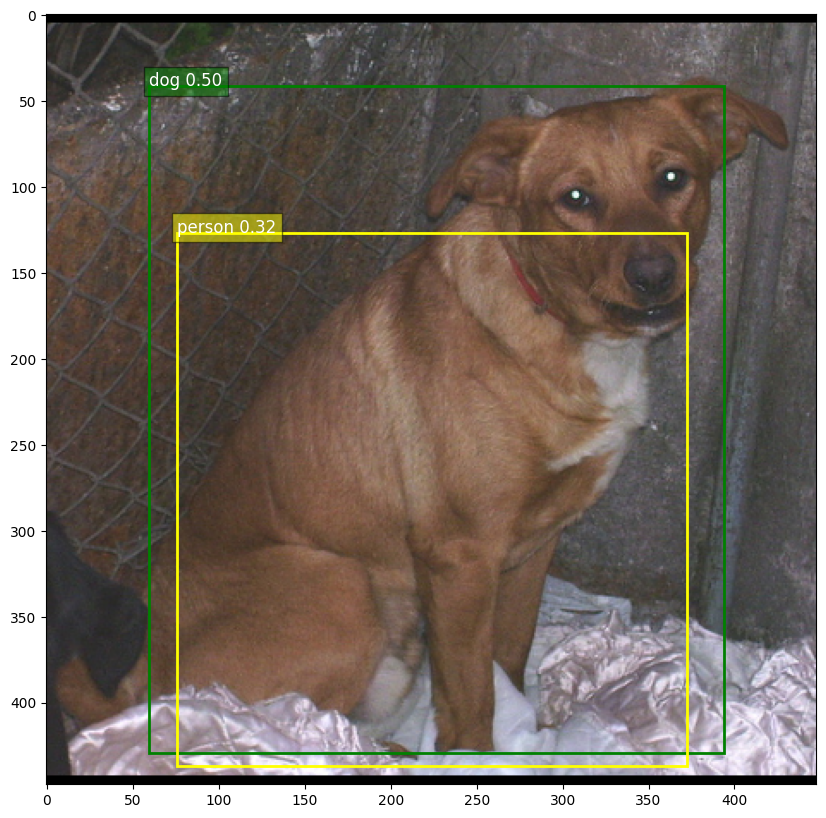

In [26]:
import random
try:
    x, labels = next(data_iter)
except:
    data_iter = iter(val_loader)
    x, labels = next(data_iter)

x = x.to(DEVICE)

idx = random.randint(0, x.shape[0] - 1)
print(f"Inspecting Image Index: {idx} in current batch...")

# 3. Predict
input_tensor = x[idx].unsqueeze(0) 
with torch.no_grad():
    predictions = model(input_tensor)

raw_conf = predictions[..., 5] 
print(f"Max Confidence Score in this image: {raw_conf.max().item():.4f}")

bboxes = convert_cell_boxes(predictions)
bboxes = bboxes[0].tolist()

nms_boxes = non_max_suppression(bboxes, iou_threshold=0.5, threshold=0.2)

print(f"Found {len(nms_boxes)} potential objects.")

input_image = x[idx].permute(1, 2, 0).cpu().numpy()
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
input_image = input_image * std + mean
input_image = np.clip(input_image, 0, 1)

visualize_inference(input_image, nms_boxes)

Inspecting Image Index: 6 in current batch...
Max Confidence Score in this image: 0.3077
Found 2 potential objects.


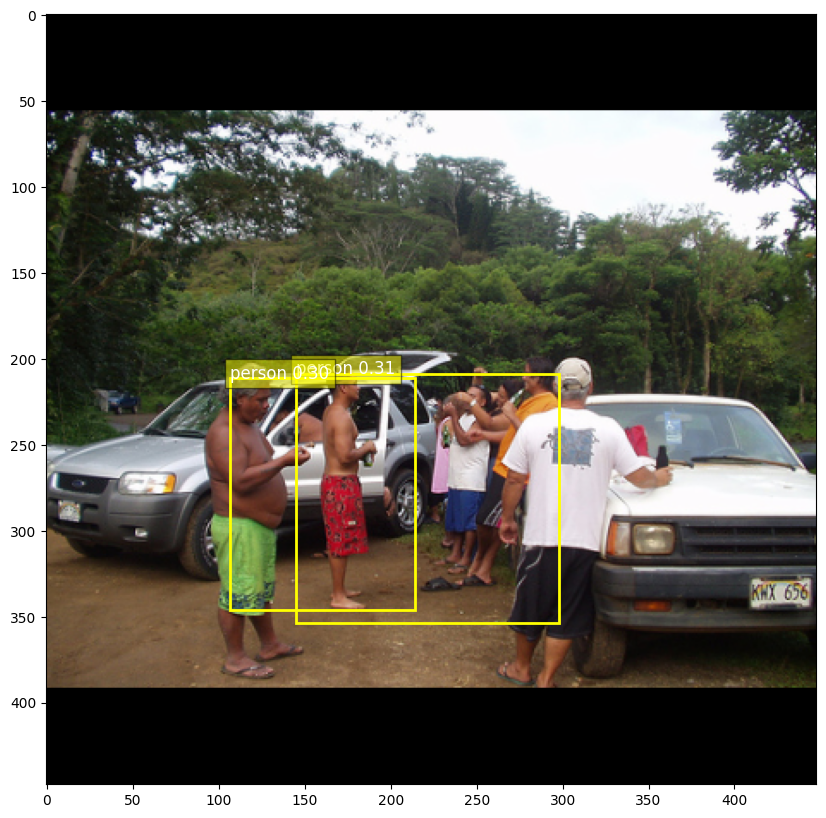

In [28]:
import random
try:
    x, labels = next(data_iter)
except:
    data_iter = iter(val_loader)
    x, labels = next(data_iter)

x = x.to(DEVICE)

idx = random.randint(0, x.shape[0] - 1)
print(f"Inspecting Image Index: {idx} in current batch...")

# 3. Predict
input_tensor = x[idx].unsqueeze(0) 
with torch.no_grad():
    predictions = model(input_tensor)

raw_conf = predictions[..., 5] 
print(f"Max Confidence Score in this image: {raw_conf.max().item():.4f}")

bboxes = convert_cell_boxes(predictions)
bboxes = bboxes[0].tolist()

nms_boxes = non_max_suppression(bboxes, iou_threshold=0.5, threshold=0.3)

print(f"Found {len(nms_boxes)} potential objects.")

input_image = x[idx].permute(1, 2, 0).cpu().numpy()
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
input_image = input_image * std + mean
input_image = np.clip(input_image, 0, 1)

visualize_inference(input_image, nms_boxes)

Inspecting Image Index: 2 in current batch...
Max Confidence Score in this image: 0.3163
Found 2 potential objects.


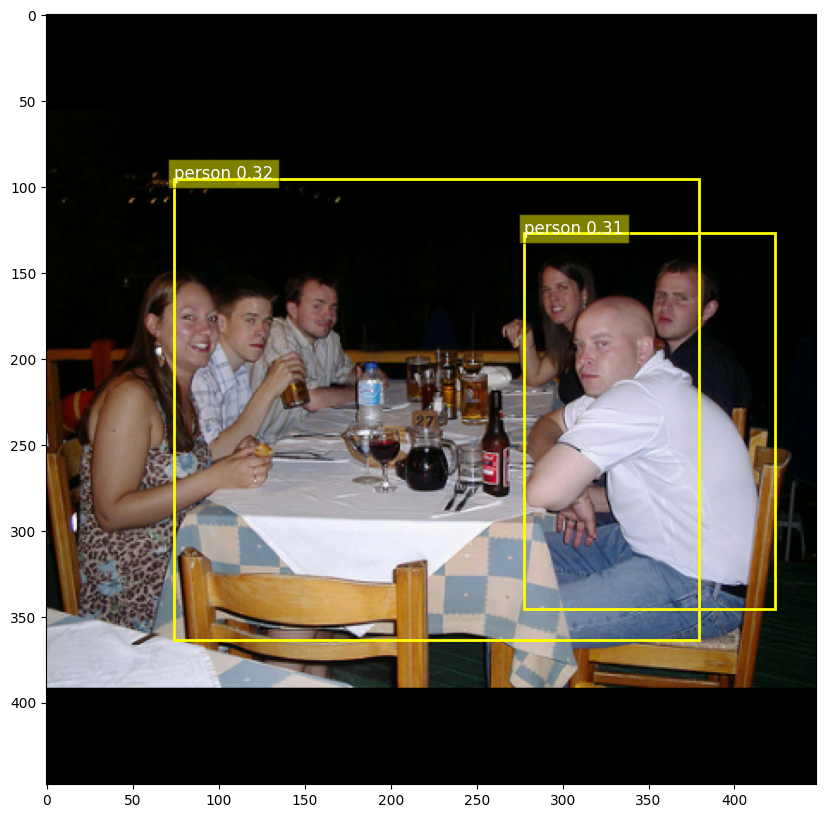

In [34]:
import random
try:
    x, labels = next(data_iter)
except:
    data_iter = iter(val_loader)
    x, labels = next(data_iter)

x = x.to(DEVICE)

idx = random.randint(0, x.shape[0] - 1)
print(f"Inspecting Image Index: {idx} in current batch...")

# 3. Predict
input_tensor = x[idx].unsqueeze(0) 
with torch.no_grad():
    predictions = model(input_tensor)

raw_conf = predictions[..., 5] 
print(f"Max Confidence Score in this image: {raw_conf.max().item():.4f}")

bboxes = convert_cell_boxes(predictions)
bboxes = bboxes[0].tolist()

nms_boxes = non_max_suppression(bboxes, iou_threshold=0.5, threshold=0.3)

print(f"Found {len(nms_boxes)} potential objects.")

input_image = x[idx].permute(1, 2, 0).cpu().numpy()
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
input_image = input_image * std + mean
input_image = np.clip(input_image, 0, 1)

visualize_inference(input_image, nms_boxes)